# Introduction

This workbook fits a Gaussian Process model to the GP and TPE Bayesian optimisation results

In [66]:
import GPy
import pandas as pd
import patsy as pt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline
import re
import pymc3 as pm
import matplotlib.ticker as tk
import re
from sklearn.model_selection import KFold
import pickle

In [67]:
df = pd.read_csv('results/all_results_average.csv')


df = df.rename(columns={'lag_time': 't', 'n_components': 'm', 'n_clusters': 'n', 'test_score': 'y'}).\
loc[:, ['basis', 'method', 'y', 't', 'm', 'n']]

to_scale = ['m', 'n', 't']
scaler = preprocessing.MinMaxScaler()
vars_scaled = pd.DataFrame(scaler.fit_transform(df.loc[:, to_scale]), columns=[x+'_s' for x in to_scale])
df = df.join(vars_scaled)
df['id']=df.groupby(['method', 'basis']).cumcount()


In [68]:
method = 'bayesian'
idx = (df['method'].isin([method])) & (~df['basis'].isin(['chi_tor'])) 
X = df.loc[idx, :].filter(regex='id|basis|_s$')
y = df.loc[idx, 'y']

In [69]:
X_c = pt.dmatrix('0+ t_s + m_s + n_s+C(basis)', data=X, return_type='dataframe')
X_c = X_c.rename(columns=lambda x: re.sub('C|\\(|\\)|\\[|\\]','',x))

# X_c = X_c.iloc[:, 1:X_c.shape[1]] # Remove intercept

## Priors

In [70]:
def gamma(alpha, beta):
    def g(x):
        return pm.Gamma(x, alpha=alpha, beta=beta)
    return g

def hcauchy(beta):
    def g(x):
        return pm.HalfCauchy(x, beta=beta)
    return g


In [71]:
def fit_model_1(y, X, kernel_type='rbf'):
    """
    function to return a pymc3 model
    y : dependent variable
    X : independent variables
    prop_Xu : number of inducing varibles to use
    
    X, y are dataframes. We'll use the column names. 
    """
    with pm.Model() as model:
        # Covert arrays
        X_a = X.values
        y_a = y.values
        X_cols = list(X.columns)
        
        # Globals
        prop_Xu = 0.1
        l_prior = gamma(1, 0.05)
        eta_prior = hcauchy(2)
        sigma_prior = hcauchy(2)

        # Kernels
        # 3 way interaction
        eta = eta_prior('eta')
        cov = eta**2
        for i in range(X_a.shape[1]):
            var_lab = 'l_'+X_cols[i]
            if kernel_type=='RBF':
                cov = cov*pm.gp.cov.ExpQuad(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type=='Exponential':
                cov = cov*pm.gp.cov.Exponential(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type=='M52':
                cov = cov*pm.gp.cov.Matern52(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])
            if kernel_type=='M32':
                cov = cov*pm.gp.cov.Matern32(X_a.shape[1], ls=l_prior(var_lab), active_dims=[i])

        # Covariance model
        cov_tot = cov 

        # Model
        gp = pm.gp.MarginalSparse(cov_func=cov_tot, approx="FITC")

        # Noise model
        sigma_n =sigma_prior('sigma_n')

        # Inducing variables
        num_Xu = int(X_a.shape[0]*prop_Xu)
        Xu = pm.gp.util.kmeans_inducing_points(num_Xu, X_a)

        # Marginal likelihood
        y_ = gp.marginal_likelihood('y_', X=X_a, y=y_a,Xu=Xu, noise=sigma_n)
        mp = pm.find_MAP()
        
    return gp, mp, model

## MML model all trials

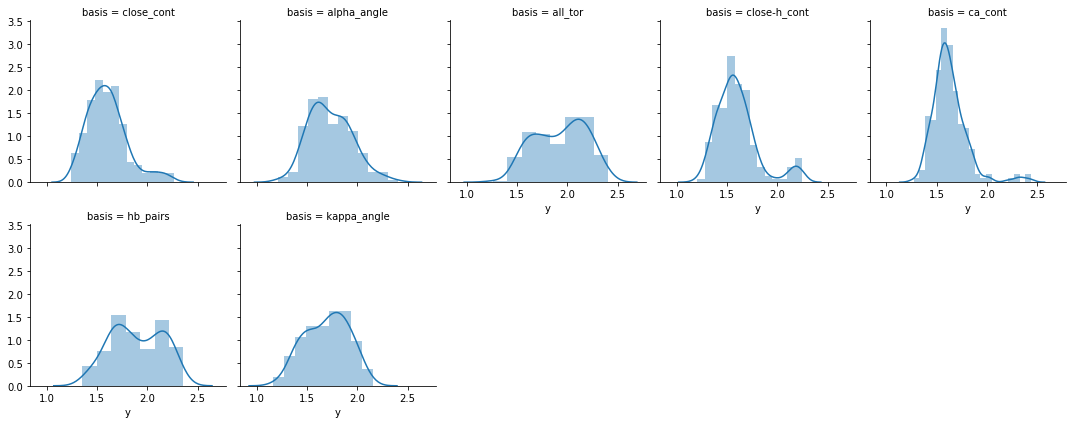

In [72]:
g = sns.FacetGrid(data=X.join(y), col='basis', col_wrap=5)
g.map(sns.distplot, 'y')

In [73]:
gp, mp, model = fit_model_1(y=y, X=X_c, kernel_type='M32')
pickle.dump(
    {'gp': gp, 'mp': mp, 'model': model},
    open('results/all_chi_{0}-opt_mml_model.p'.format(method), 'wb')
)

 /Users/robertarbon/OneDrive - University of Bristol/Research/optimize_fs_peptide/opt_fs_pep/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
logp = 728.04, ||grad|| = 0.13241: 100%|██████████| 98/98 [00:28<00:00,  3.44it/s]    


In [75]:
with model:
    mu, var = gp.predict(X_c.values, point=mp, diag=True,pred_noise=False)


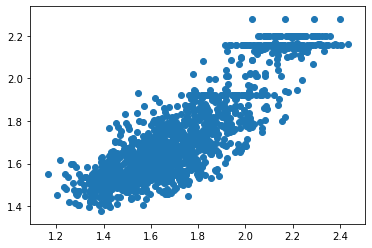

In [77]:
g = sns.FacetGrid(X_c.join(mu).join(y))

In [89]:
?pd.DataFrame.duplicated

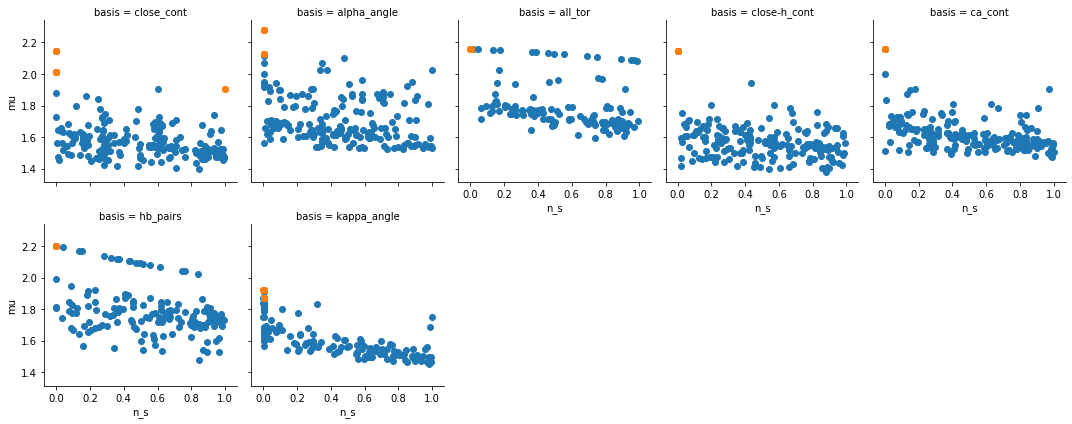

In [95]:
tmp = X.assign(**{'mu':mu}).join(y)
tmp['dupe']=tmp.duplicated(subset='mu', keep=False )

g = sns.FacetGrid(tmp, hue='dupe', col='basis', col_wrap=5)
g.map(plt.scatter, 'n_s', 'mu')

In [101]:
?pd.DataFrame.rank